## Predict Future Sales (Time Series)

Kaggle Competition

**Goal**: Predict total sales for every product and store for November 2015. <br>
**Data Given**: Daily historical data from January 2013 to October 2015. <br>

#### 1. Import packages and data

In [2]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats

# Visualistion
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import all of them 
sales=pd.read_csv("sales_train.csv")
# item_cat=pd.read_csv("item_categories-translated.csv")
# item=pd.read_csv("items-translated.csv")
# sub=pd.read_csv("sample_submission.csv")
# shops=pd.read_csv("shops-translated.csv")
test=pd.read_csv("test.csv")

Thanks to deargle who translated the Russian to English. <br>
https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/discussion/54949

#### 2. Compress data size

In [4]:
def downcast_dtypes(df, verbose = True):
    start_mem = df.memory_usage().sum() / 1024**2
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

sales = downcast_dtypes(sales, verbose = True)
print(sales.info())

Mem. usage decreased to 61.60 Mb (54.2% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int16  
 2   shop_id         int16  
 3   item_id         int16  
 4   item_price      float32
 5   item_cnt_day    float32
dtypes: float32(2), int16(3), object(1)
memory usage: 61.6+ MB
None


The data is now much lighter!!

#### 3. Data Structure

In [5]:
# Check Null values
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Great, there is no missing values.

In [6]:
# Check how many rows & columns
sales.shape

(2935849, 6)

Almost 3 miliion rows of data.

In [7]:
# check duplicates
sales[sales.duplicated()]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


Nothing much to worry about for the duplicates, might be just the same purchase in the same shop from different people.

#### 4. Feature Extraction

##### 4.1 Convert 'date' column to datetime format for future extraction purpose.

In [8]:
## Before converting date to datetime format
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
2,05.01.2013,0,25,2552,899.000000,-1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0


In [ ]:
# convert date to datetime format
# sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
sales.date = pd.to_datetime(sales.date, format = '%d.%m.%Y')
# check
print(sales.info())

In [ ]:
## After converting date to datetime format
sales.head()

##### 4.2 Calculate sales revenue

In [ ]:
sales['revenue'] = sales.item_price.values * sales.item_cnt_day.values

In [ ]:
sales.head()

In [ ]:
# Number of returns
len(sales[sales.item_cnt_day < 0])

##### 4.3 Split year, month and day in each column

In [ ]:
sales['month'] = sales.date.dt.month
sales['year'] = sales.date.dt.year
sales['day_of_week'] = sales.date.dt.day_of_week

In [ ]:
sales.head()

##### 4.4 Aggregate sales by month

In [ ]:
sales['Month'] = sales['date'].dt.to_period('M')

In [ ]:
sales.head()

In [ ]:
salesPerMonth = sales.groupby(['Month']).agg({'item_cnt_day' : 'sum'})
salesPerMonth.reset_index(inplace=True)
salesPerMonth = salesPerMonth.set_index('Month')
salesPerMonth.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
salesPerMonth.plot()

#### 5. Time Series Analysis

##### 5.1 Time Series Decomposition

-> To obeserve underlying patterns such as trend, seasonality, cycle and irregular remainder

In [19]:
salesPerMonth.item_cnt_month.values

array([131479., 128090., 147142., 107190., 106970., 125381., 116966.,
       125291., 133332., 127541., 130009., 183342., 116899., 109687.,
       115297.,  96556.,  97790.,  97429.,  91280., 102721.,  99208.,
       107422., 117845., 168755., 110971.,  84198.,  82014.,  77827.,
        72295.,  64114.,  63187.,  66079.,  72843.,  71056.],
      dtype=float32)

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

salesPerMonth.item_cnt_month.interpolate(inplace = True)
salesPerMonth.item_cnt_month.index=salesPerMonth.item_cnt_month.index.to_timestamp()
decompose = seasonal_decompose(salesPerMonth.item_cnt_month,model='multiplicative', extrapolate_trend=8)
# decompose = seasonal_decompose(salesPerMonth.item_cnt_month,model='multiplicative', extrapolate_trend=8)

Text(0.5, 0.98, 'Decomposition of Time Series')

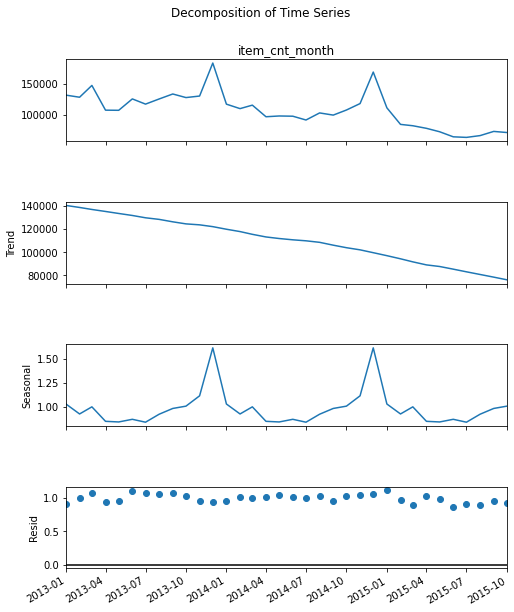

In [22]:
fig = decompose.plot()
fig.set_figheight(10)
fig.set_figwidth(8)
fig.autofmt_xdate(rotation=30)
fig.suptitle('Decomposition of Time Series')

##### 5.2 Check stationarity

In [26]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("ADF : ",dftest[0])
     print("P-Value : ", dftest[1])
     print("Num Of Lags : ", dftest[2])
     print("Num Of Observations Used For ADF Regression:",      dftest[3])
     print("Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

# https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53
# p < 0.05 -> stationary
# p > 0.05 -> not stationary

In [28]:
test_stationarity(salesPerMonth['item_cnt_month'])

ADF :  -2.395704066994433
P-Value :  0.1429525769929046
Num Of Lags :  0
Num Of Observations Used For ADF Regression: 33
Critical Values :
	 1% :  -3.6461350877925254
	 5% :  -2.954126991123355
	 10% :  -2.6159676124885216


#### 6. Model Fitting

##### 6.1 Train test split

In [30]:
STEPS = 24
period = 9

<AxesSubplot:xlabel='Month'>

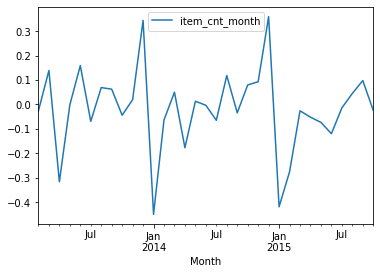

In [31]:
log_sales = np.log(salesPerMonth)
salesPerMonthShift = log_sales - log_sales.shift()
salesPerMonthShift.dropna(inplace=True)
salesPerMonthShift.plot()

In [42]:
test_stationarity(salesPerMonthShift['item_cnt_month'])

ADF :  -6.974166116899575
P-Value :  8.513043398888736e-10
Num Of Lags :  10
Num Of Observations Used For ADF Regression: 22
Critical Values :
	 1% :  -3.769732625845229
	 5% :  -3.005425537190083
	 10% :  -2.6425009917355373


Train dates : 2013-02 --- 2015-01  (n=24)
Test dates  : 2015-02 --- 2015-10  (n=9)


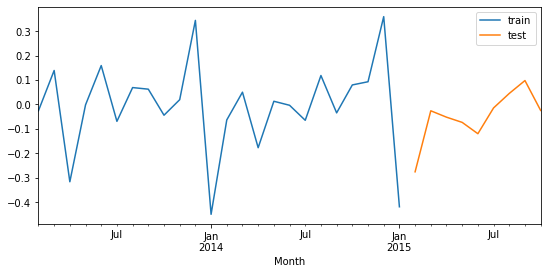

In [32]:
train = salesPerMonthShift[:STEPS]
test = salesPerMonthShift[STEPS:]

print(f"Train dates : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

fig, ax = plt.subplots(figsize=(9, 4))
train['item_cnt_month'].plot(ax=ax, label='train')
test['item_cnt_month'].plot(ax=ax, label='test')
ax.legend()

##### 6.2 ARIMA

In [29]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(salesPerMonth['item_cnt_month'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=760.247, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=760.752, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=760.715, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=758.472, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=762.780, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.581 seconds


In [34]:
import statsmodels.api as sm
model=sm.tsa.arima.ARIMA(train['item_cnt_month'],order=(0,1,0))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         item_cnt_month   No. Observations:                   24
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  -5.553
Date:                Thu, 11 Aug 2022   AIC                             13.106
Time:                        11:36:47   BIC                             14.242
Sample:                    02-28-2013   HQIC                            13.392
                         - 01-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0949      0.022      4.276      0.000       0.051       0.138
===================================================================================
Ljung-Box (L1) (Q):                   6.32   Jarque-Bera (JB):                 6.47
Prob(Q):                              0.01   Prob(JB):                         0.04
Heteroskedasticity (H):               1.70   Skew:                            -1.22
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 7. Prediction and validation

#### 8. Submission